<a href="https://colab.research.google.com/github/MiguelHRSDE/W-Net/blob/loop/W_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inicialization**


In [1]:
# first some extra packages we're gonna need
!pip3 install coloredlogs
!pip install -q git+https://github.com/tensorflow/examples.git

%tensorflow_version 2.x
import tensorflow as tf

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np 
import numpy as np
from tensorflow.python.keras import layers

from tensorflow.python.keras.layers import (Activation, AveragePooling2D,
                                            BatchNormalization, Conv2D, Conv3D,
                                            Dense, Flatten,
                                            GlobalAveragePooling2D,
                                            GlobalMaxPooling2D, Input,
                                            MaxPooling2D, MaxPooling3D,
                                            Reshape, Dropout, concatenate,
											UpSampling2D)
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K_B
import coloredlogs
from os.path import exists
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

print(tf.__version__)



TensorFlow 2.x selected.
2.1.0-rc1


# **Sof normalized cut loss implementation**

In [2]:
def edge_weights(flatten_image, rows , cols, std_intensity=3, std_position=1, radius=5):
	'''
	Inputs :
	flatten_image : 1 dim tf array of the row flattened image ( intensity is the average of the three channels) 
	std_intensity : standard deviation for intensity 
	std_position : standard devistion for position
	radius : the length of the around the pixel where the weights 
	is non-zero
	rows : rows of the original image (unflattened image)
	cols : cols of the original image (unflattened image)

	Output : 
	weights :  2d tf array edge weights in the pixel graph

	Used parameters :
	n : number of pixels 
	'''
	A = outer_product(flatten_image, tf.ones_like(flatten_image))
	A_T = tf.transpose(A)
	intensity_weight = tf.exp(-1*tf.square((tf.divide((A - A_T), std_intensity))))

	xx, yy = tf.meshgrid(tf.range(rows), tf.range(cols))
	xx = tf.reshape(xx, (rows*cols,))
	yy = tf.reshape(yy, (rows*cols,))
	A_x = outer_product(xx, tf.ones_like(xx))
	A_y = outer_product(yy, tf.ones_like(yy))

	xi_xj = A_x - tf.transpose(A_x)
	yi_yj = A_y - tf.transpose(A_y)

	sq_distance_matrix = tf.square(xi_xj) + tf.square(yi_yj)

	dist_weight = tf.exp(-tf.divide(sq_distance_matrix,tf.square(std_position)))
	dist_weight = tf.cast(dist_weight, tf.float32)
	print (dist_weight.get_shape())
	print (intensity_weight.get_shape())
	weight = tf.multiply(intensity_weight, dist_weight)


	# ele_diff = tf.reshape(ele_diff, (rows, cols))
	# w = ele_diff + distance_matrix
	'''
	for i in range(n):
		for j in range(n):
			# because a (x,y) in the original image responds in (x-1)*cols + (y+1) in the flatten image
			x_i= (i//cols) +1 
			y_i= (i%cols) - 1
			x_j= (j//cols) + 1
			y_j= (j%cols) - 1
			distance = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2)
			if (distance < radius):
				w[i][j] = tf.exp(-((flatten_image[i]- flatten_image[j])/std_intensity)**2) * tf.exp(-(distance/std_position)**2)
	# return w as a lookup table			
	'''
	return weight

def outer_product(v1,v2):
	'''
	Inputs:
	v1 : m*1 tf array
	v2 : m*1 tf array

	Output :
	v1 x v2 : m*m array
	'''
	v1 = tf.reshape(v1, (-1,))
	v2 = tf.reshape(v2, (-1,))
	v1 = tf.expand_dims((v1), axis=0)
	v2 = tf.expand_dims((v2), axis=0)
	return tf.matmul(tf.transpose(v1),(v2))

def numerator(k_class_prob,weights):

	'''
	Inputs :
	k_class_prob : k_class pixelwise probability (rows*cols) tensor 
	weights : edge weights n*n tensor 
	'''
	k_class_prob = tf.reshape(k_class_prob, (-1,))	
	return tf.reduce_sum(tf.multiply(weights,outer_product(k_class_prob,k_class_prob)))

def denominator(k_class_prob,weights):	
	'''
	Inputs:
	k_class_prob : k_class pixelwise probability (rows*cols) tensor
	weights : edge weights	n*n tensor 
	'''
	k_class_prob = tf.cast(k_class_prob, tf.float32)
	k_class_prob = tf.reshape(k_class_prob, (-1,))	
	return tf.reduce_sum(tf.multiply(weights,outer_product(k_class_prob,tf.ones(tf.shape(k_class_prob)))))

def soft_n_cut_loss(flatten_image,prob, k, rows, cols):
	'''
	Inputs: 
	prob : (rows*cols*k) tensor 
	k : number of classes (integer)
	flatten_image : 1 dim tf array of the row flattened image ( intensity is the average of the three channels)
	rows : number of the rows in the original image
	cols : number of the cols in the original image

	Output : 
	soft_n_cut_loss tensor for a single image

	'''

	soft_n_cut_loss = k
	weights = edge_weights(flatten_image, rows ,cols)
	
	for t in range(k): 
		soft_n_cut_loss = soft_n_cut_loss - (numerator(prob[:,:,t],weights)/denominator(prob[:,:,t],weights))

	return soft_n_cut_loss
	# return soft_n_cut_loss



print('check')

check


# **Download the Oxford-IIIT Pets dataset**

In [0]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (64, 64))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (64, 64))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (64, 64))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (64, 64))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 12
BUFFER_SIZE = 500
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

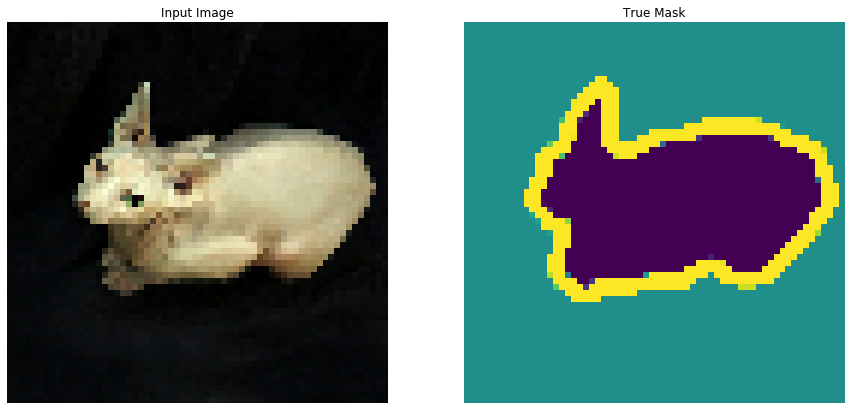

In [4]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# **Constructing the W-Net**

## Define the model

In [0]:
img_rows = 64
img_cols = 64
num_classes = 3
bn_axis=3
display_step = 20

## Define encode/decode blocks

In [0]:
def enc_conv_block(inputs, filters=[128,128], kernel_size=[3,3], activation='relu', kernel_initializer='he_normal', block='', module='', pre_pool=True):
		fa, fb = filters
		ka, kb = kernel_size
		conv1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_enc_'+block+'_1')(inputs)
		conv1 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_enc_'+block+'_2')(conv1)
		conv1 = BatchNormalization(axis=bn_axis, name=module+'_bn_enc_'+block+'_3')(conv1)
		conv1 = Dropout(0.65,  name=module+'_dropout_enc_'+block)(conv1)
		pool1 = MaxPooling2D(pool_size=(2,2), name=module+'_maxpool_enc_'+block+'_4')(conv1)
		# tf.summary.histogram(module+'_maxpool_enc_'+block+'_4',pool1)
		if not pre_pool:
			return pool1
		else:
			return conv1,pool1

def dec_conv_block(inputs, filters=[128, 128, 128], kernel_size=[2,3,3], activation='relu', kernel_initializer='he_normal', block='', module=''):
		previous_layer, concat_layer = inputs
		fa, fb, fc = filters
		ka, kb, kc = kernel_size
		up1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_dec_'+block+'_2')(UpSampling2D(size=(2,2), name=module+'_upsam_block_'+block+'_1')(previous_layer))
		# print (up1.get_shape())
		merge1 = concatenate([concat_layer, up1], name=module+'_concat_'+block+'_3')
		conv2 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_dec_'+block+'_4')(merge1)
		conv3 = Conv2D(fc, kc, activation=activation, padding='same', kernel_initializer=kernel_initializer,name=module+'_conv_dec_'+block+'_5')(conv2)
		conv3 = Dropout(0.65, name=module+'_dropout_dec_'+block)(conv3)
		conv3 = BatchNormalization(axis=bn_axis, name=module+'_bn_dec_'+block+'_6')(conv3)
		# tf.summary.histogram(module+'_bn_dec_'+block+'_6', conv3)
		return conv3

def join_enc_dec(inputs, filters=[1024,1024], kernel=[3,3],activation='relu', kernel_initializer='he_normal', module='', block='join'):	
		fa, fb = filters
		ka, kb = kernel
		conv1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+"_join_conv_1")(inputs)
		conv1 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+"_join_conv_2")(conv1)
		conv1 = BatchNormalization(axis=bn_axis, name=module+'_join_bn_3_')(conv1)
		conv1 = Dropout(0.65, name=module+'_join_dropout_4')(conv1)
		# tf.summary.histogram(module+'_join_bn_3_', conv1)
		return conv1

## Define U-enc / U-dec

In [0]:
def uenc (input_size=(-1,img_rows,img_cols,3), input_tensor=None, output_layers=2,module=''):
		
		if input_tensor is None:
			inputs = Input(input_size)
		else:
			inputs = input_tensor
		bn_axis=3
		with tf.name_scope(module+'_Encoder'):
			prepool_1, layer1 = enc_conv_block(inputs, [64, 64], [3,3], block='a', module=module)
			prepool_2, layer2 = enc_conv_block(layer1, [128,128], [3,3], block='b', module=module)
			prepool_3, layer3 = enc_conv_block(layer2, [256,256], [3,3], block='c', module=module)
			prepool_4, layer4 = enc_conv_block(layer3, [512,512], [3,3], block='d', module=module)

			layer4 = Dropout(0.65)(layer4)

			join_layer = join_enc_dec(layer4, [1024,1024], [3,3], module=module)
		with tf.name_scope(module+'_Decoder'):
			layer4 = dec_conv_block([join_layer, prepool_4], [512,512,512], [2,3,3], block='d', module=module)
			layer3 = dec_conv_block([layer4, prepool_3], [256,256,256], [2,3,3], block='c', module=module)
			layer2 = dec_conv_block([layer3, prepool_2], [128,128,128], [2,3,3], block='b', module=module)
			layer1 = dec_conv_block([layer2, prepool_1], [64,64,64], [2,3,3], block='a', module=module)

			layer0 = Conv2D(8, 1, kernel_initializer='he_normal', padding='same', activation='relu', name=module+'_conv_output_layer')(layer1)
			output = Conv2D(output_layers, 1, kernel_initializer='he_normal', name=module+'_output_layer')(layer0)

		return output, layer0

def udec (input_size=(-1,img_rows,img_cols,3), input_tensor=None, loop_tensor=None, output_layers=3,module=''):
		
		if input_tensor is None:
			inputs = Input(input_size)
		else:
			inputs = input_tensor
		bn_axis=3
		with tf.name_scope(module+'_Encoder'):
			inputs = concatenate([inputs, loop_tensor], name=module+'_concat_initial')
			prepool_1, layer1 = enc_conv_block(inputs, [64, 64], [3,3], block='a', module=module)
			prepool_2, layer2 = enc_conv_block(layer1, [128,128], [3,3], block='b', module=module)
			prepool_3, layer3 = enc_conv_block(layer2, [256,256], [3,3], block='c', module=module)
			prepool_4, layer4 = enc_conv_block(layer3, [512,512], [3,3], block='d', module=module)

			layer4 = Dropout(0.65)(layer4)

			join_layer = join_enc_dec(layer4, [1024,1024], [3,3], module=module)
		with tf.name_scope(module+'_Decoder'):
			layer4 = dec_conv_block([join_layer, prepool_4], [512,512,512], [2,3,3], block='d', module=module)
			layer3 = dec_conv_block([layer4, prepool_3], [256,256,256], [2,3,3], block='c', module=module)
			layer2 = dec_conv_block([layer3, prepool_2], [128,128,128], [2,3,3], block='b', module=module)
			layer1 = dec_conv_block([layer2, prepool_1], [64,64,64], [2,3,3], block='a', module=module)

			output = Conv2D(output_layers, 1, kernel_initializer='he_normal', name=module+'_output_layer')(layer1)

		return output

## Define W-Net

In [0]:
def encoder(num_classes, input_shape=[-1,img_rows,img_cols,3], input_tensor = None):
		if input_tensor is None:
			img_input = Input(shape=input_shape)
		else:
			img_input = input_tensor
		x, loop = uenc(input_tensor = img_input, output_layers=num_classes, module='ENCODER')
		output = tf.nn.softmax(x, axis=3)
		return loop, output
def decoder(input_shape=[-1, img_rows,img_cols,3], input_tensor=None, loop_tensor=None):
		if input_tensor is None:
			img_input = Input(shape=input_shape)
		else:
			img_input = input_tensor
		x = udec(input_tensor = img_input, loop_tensor = loop_tensor, output_layers=3, module='DECODER') # 3 because  of number of channels
		return (x)


In [0]:
def wnet(num_classes):
  inputs = tf.keras.layers.Input(shape=[64, 64, 3])
  x = inputs
  loop, output = encoder(num_classes, input_tensor = x)
  decode = decoder(input_tensor=output, loop_tensor=loop)
  #return(output, decode)
  return tf.keras.Model(inputs=x, outputs=[output, decode])

Compile the model


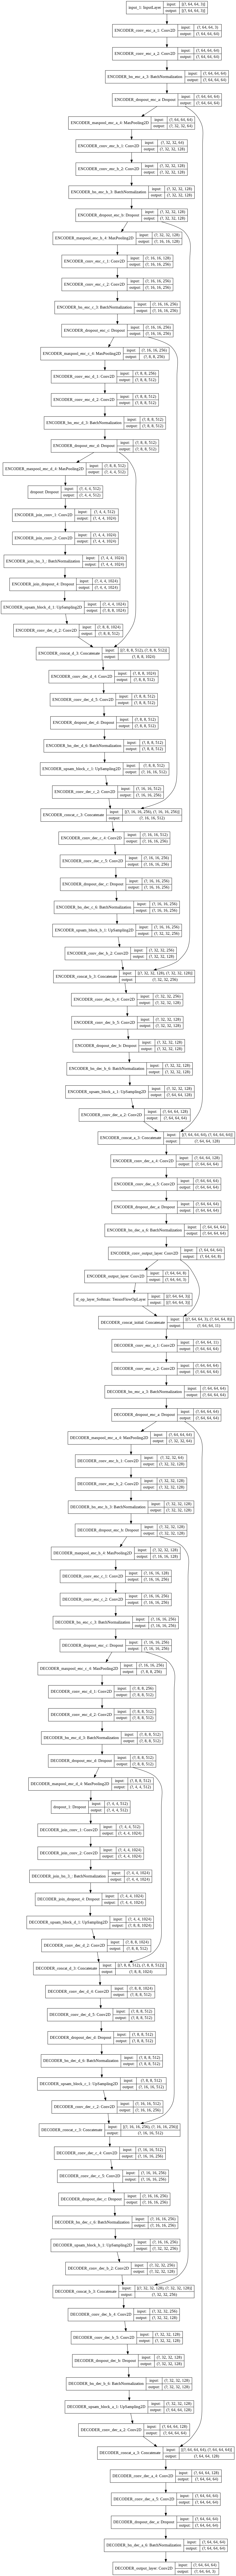

In [10]:
model = wnet(num_classes)
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
ENCODER_conv_enc_a_1 (Conv2D)   (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
ENCODER_conv_enc_a_2 (Conv2D)   (None, 64, 64, 64)   36928       ENCODER_conv_enc_a_1[0][0]       
__________________________________________________________________________________________________
ENCODER_bn_enc_a_3 (BatchNormal (None, 64, 64, 64)   256         ENCODER_conv_enc_a_2[0][0]       
______________________________________________________________________________________________

## Seting up the model: learning rate, optimizer, loss function and trainable weights

In [0]:
#Instantiate learning rate
start_learning_rate = 1e-5 #0.000001
# lr = tf.train.exponential_decay(start_learning_rate, global_step_tensor, 5000, 0.999, staircase=True) #TF1
lr = tf.keras.optimizers.schedules.ExponentialDecay(start_learning_rate, decay_steps=5000, decay_rate=0.999, staircase=True)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Instantiate the loss functions.
def custom_loss(x, decode, output):
    soft_map = (x, output)
    loss = tf.map_fn(lambda x:soft_n_cut_loss(tf.reshape(tf.image.rgb_to_grayscale(x[0]), (img_rows*img_cols,)), tf.reshape(x[1], (img_rows, img_cols, num_classes)), num_classes, img_rows, img_cols), soft_map, dtype=x.dtype)
    loss = tf.reduce_mean(loss)/2
    recons_map = (x, decode)
    recons_loss = tf.map_fn(lambda x: tf.reduce_mean(tf.square(x[0] - x[1])), recons_map, dtype=x.dtype)
    recons_loss = tf.reduce_mean(recons_loss)*10
		#tf.summary.scalar('soft_n_cut_loss', loss)
		#tf.summary.scalar('reconstruction_loss', recons_loss)
    return loss, recons_loss


In [0]:
#Defining functions for visualizing

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

# **Training**

Start of epoch 0
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


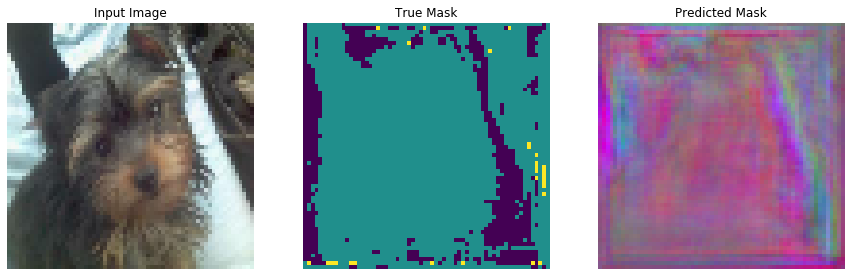

Training loss (for one batch) at step 0: loss: 0.9766814708709717 recons_loss: 1.9610309600830078
Seen so far: 12 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


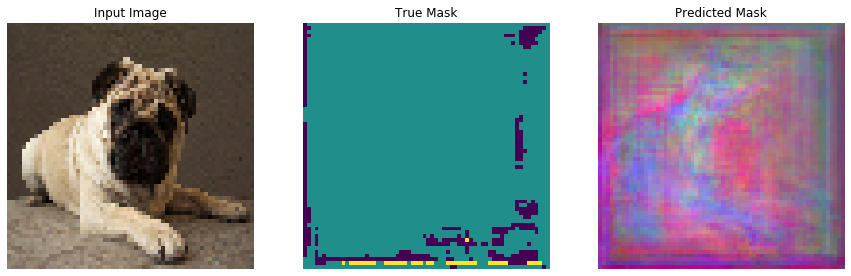

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


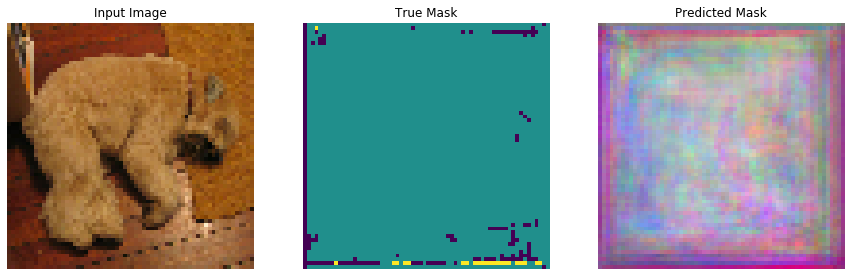

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


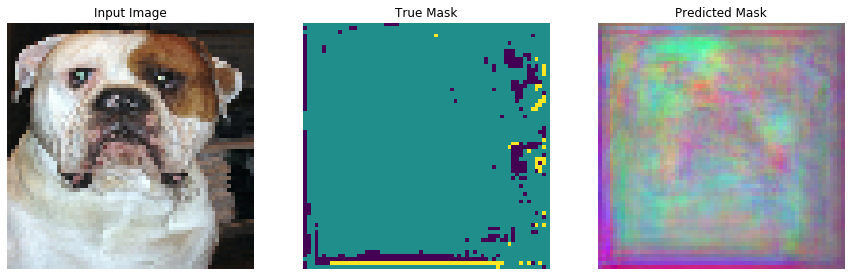

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


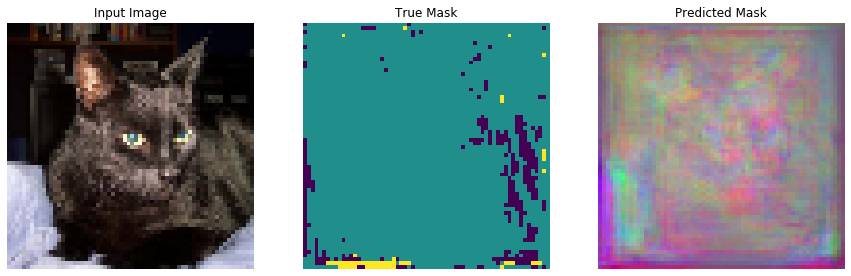

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


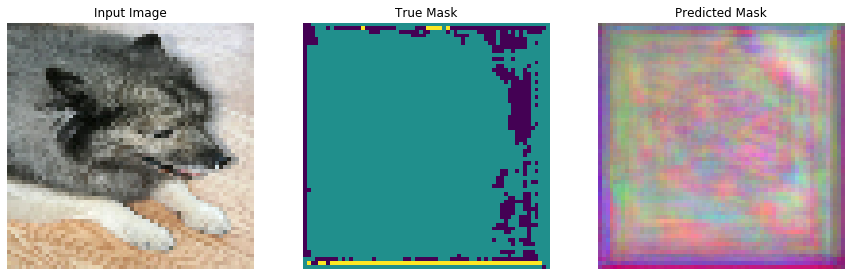

Training loss (for one batch) at step 5: loss: 0.9641988277435303 recons_loss: 0.767826497554779
Seen so far: 72 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


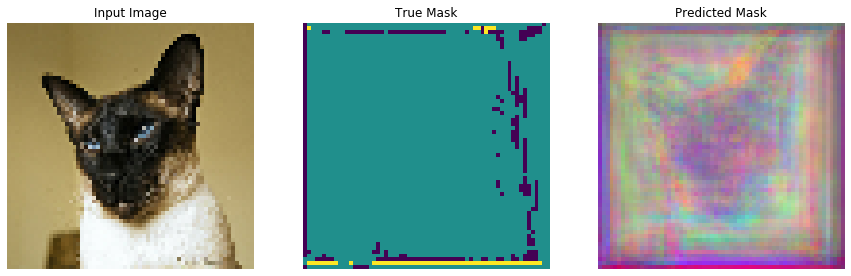

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


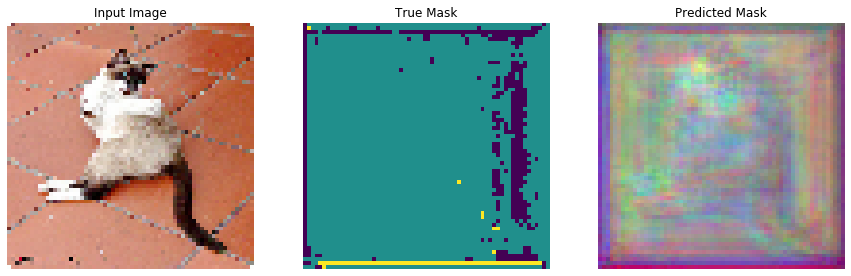

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


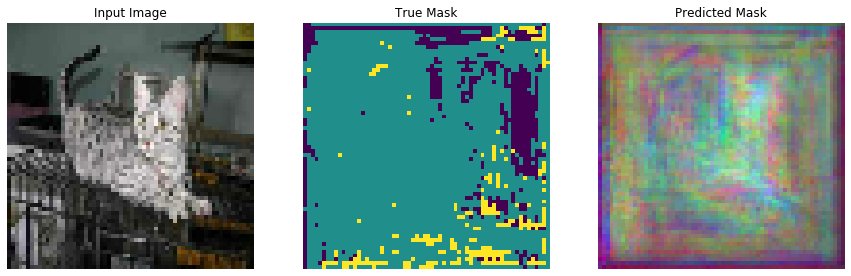

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


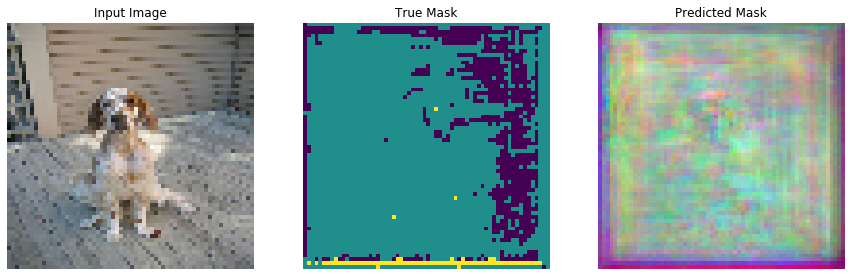

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


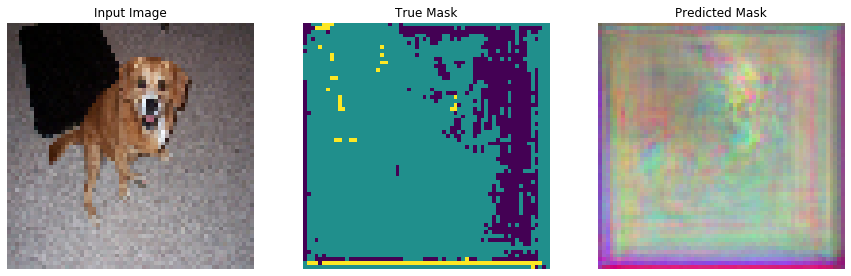

Training loss (for one batch) at step 10: loss: 0.9663155674934387 recons_loss: 0.6755698323249817
Seen so far: 132 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


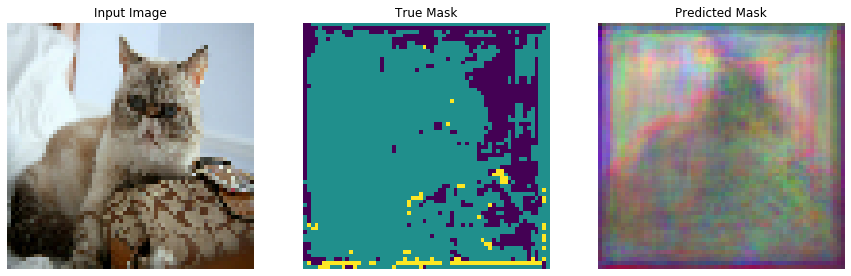

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


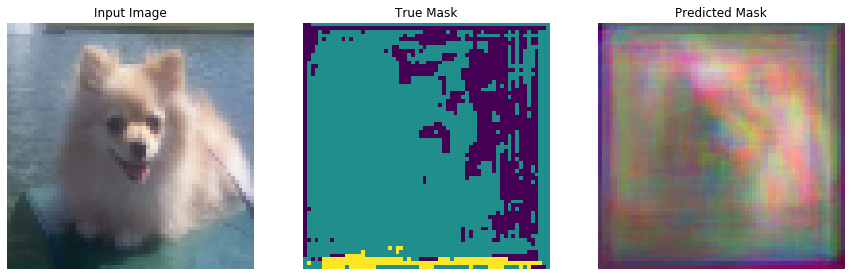

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


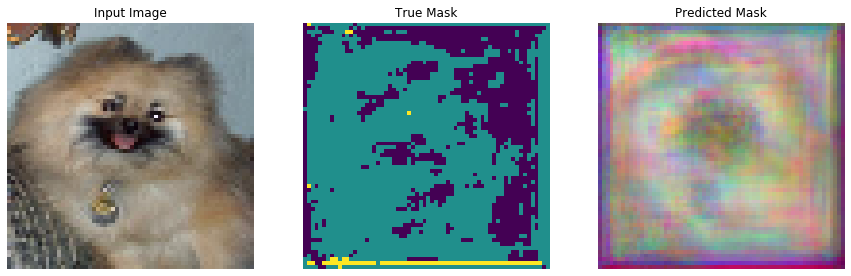

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


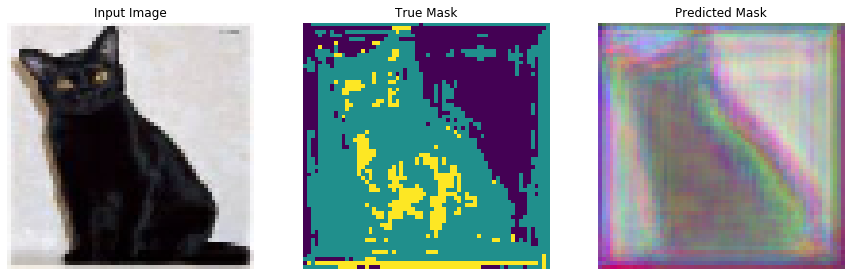

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


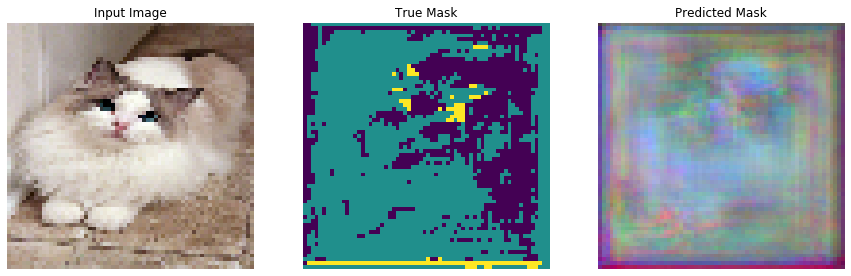

Training loss (for one batch) at step 15: loss: 0.9689121246337891 recons_loss: 0.6429786086082458
Seen so far: 192 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


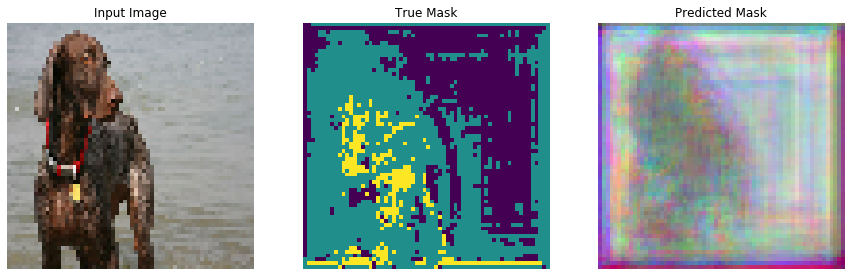

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


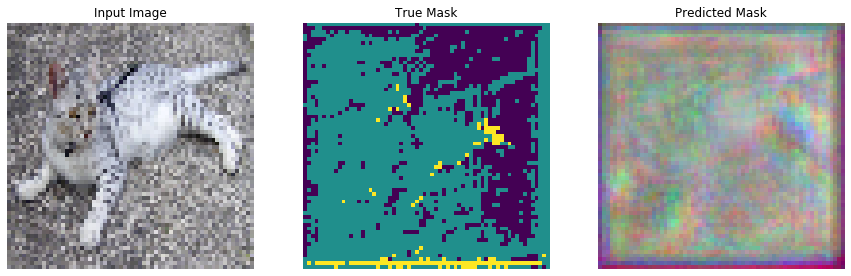

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


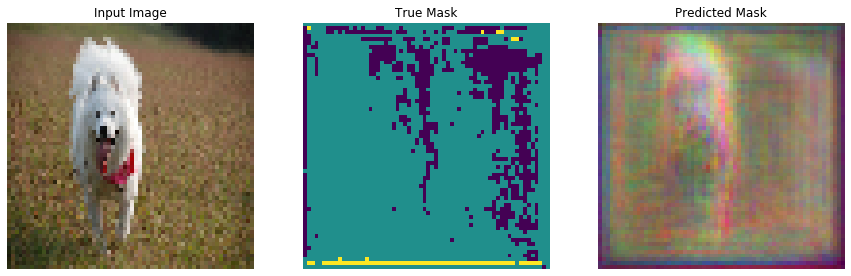

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


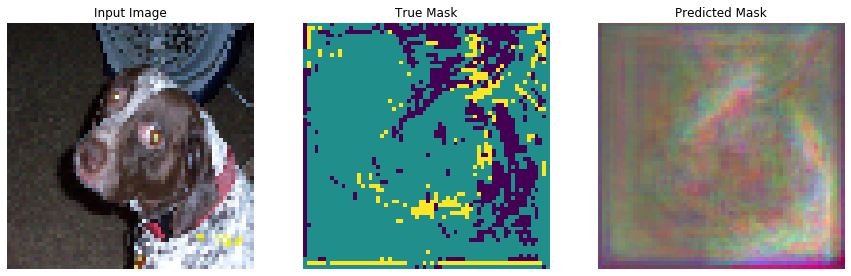

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


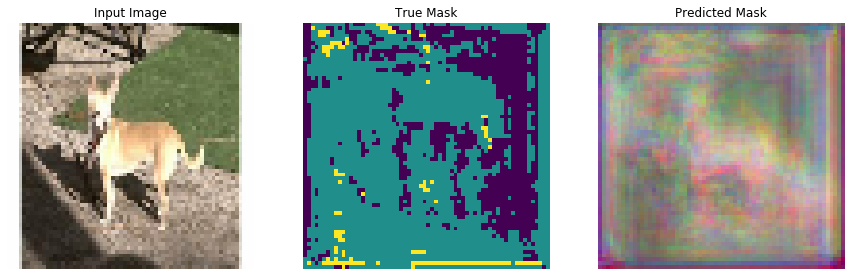

Training loss (for one batch) at step 20: loss: 0.9597621560096741 recons_loss: 0.571174144744873
Seen so far: 252 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


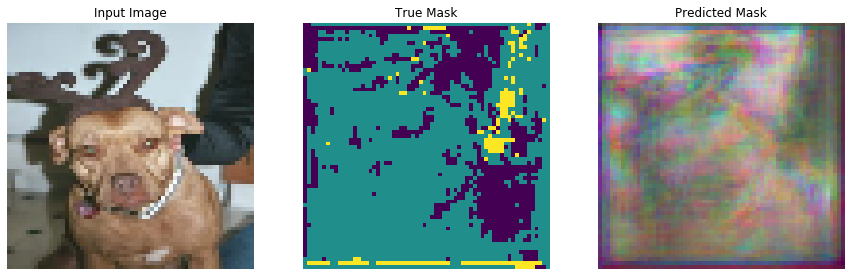

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


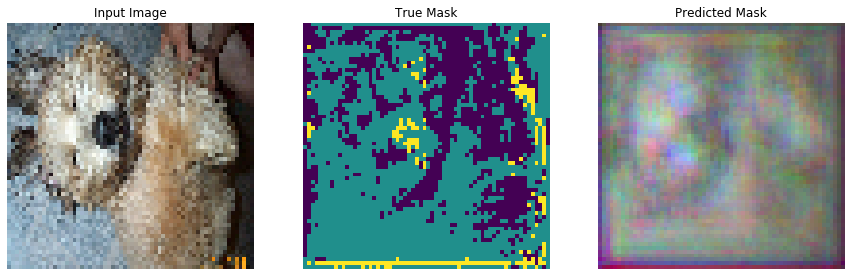

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


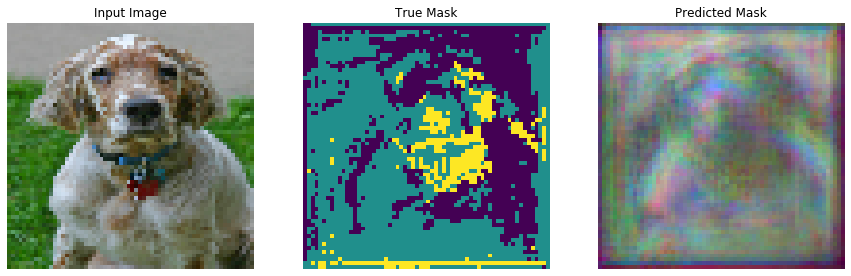

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


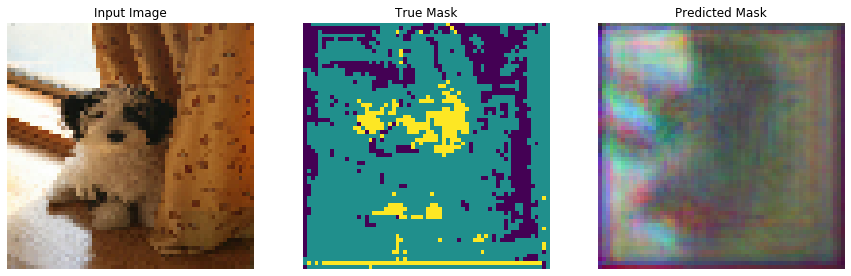

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


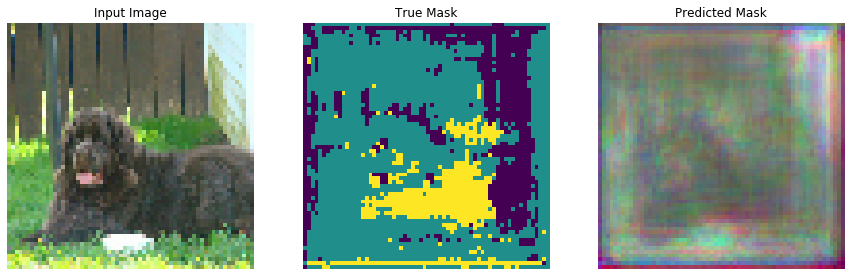

Training loss (for one batch) at step 25: loss: 0.9638473391532898 recons_loss: 0.463284969329834
Seen so far: 312 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


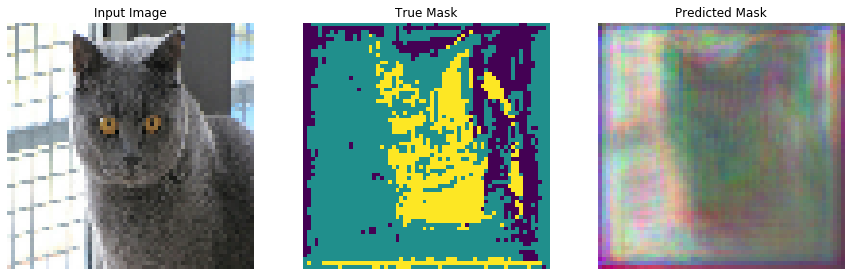

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


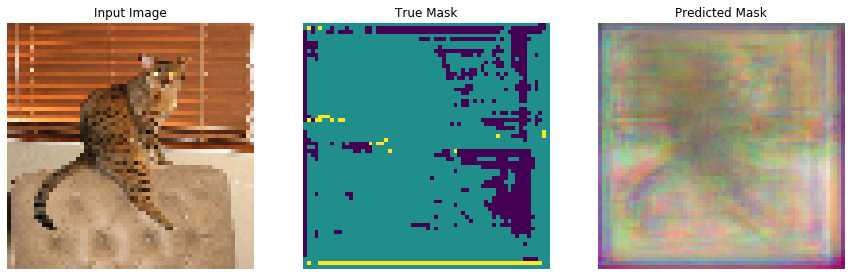

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


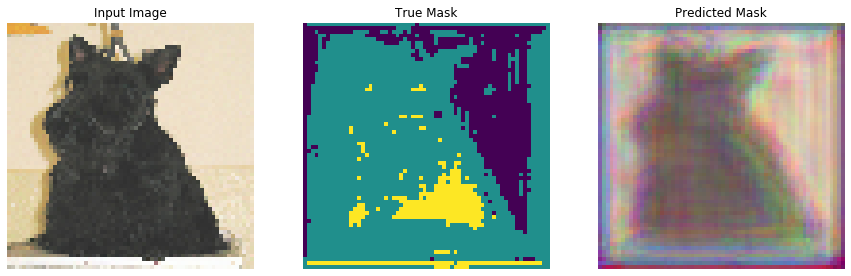

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


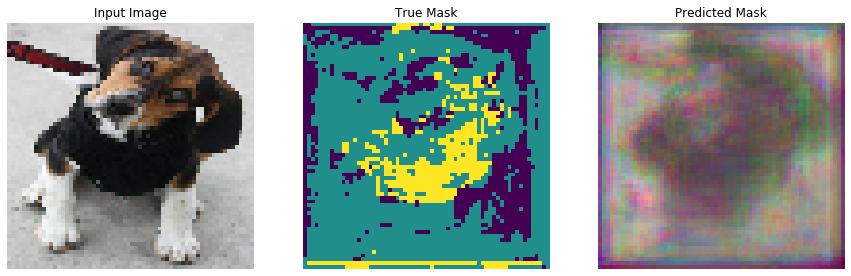

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


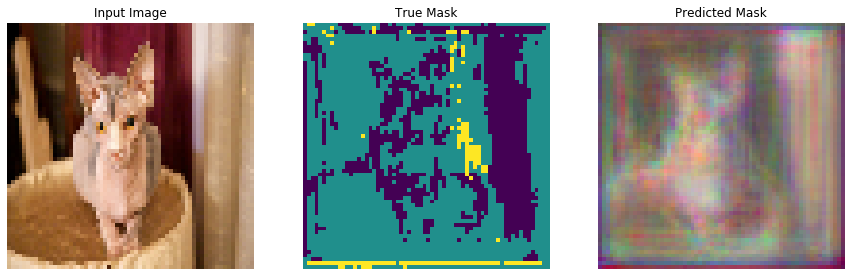

Training loss (for one batch) at step 30: loss: 0.9643759727478027 recons_loss: 0.36015796661376953
Seen so far: 372 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


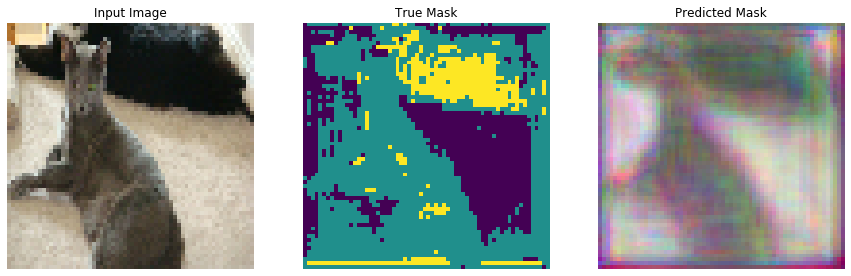

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


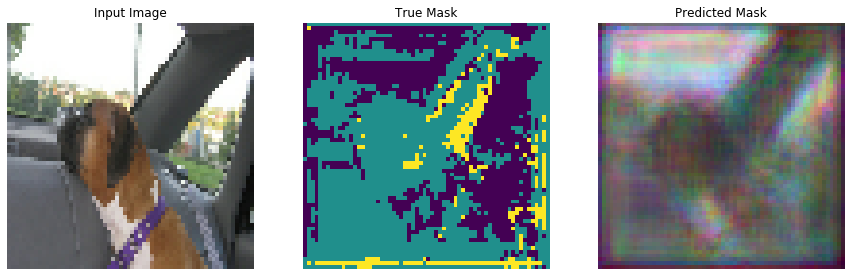

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


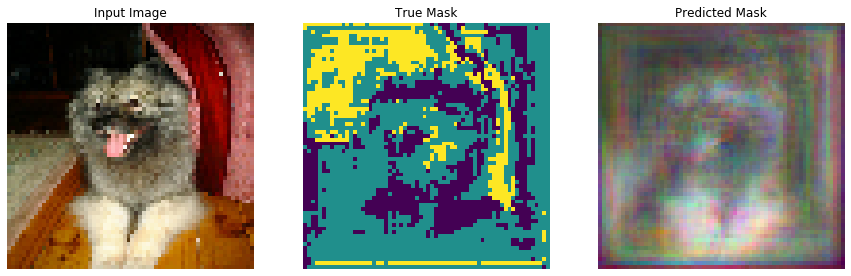

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


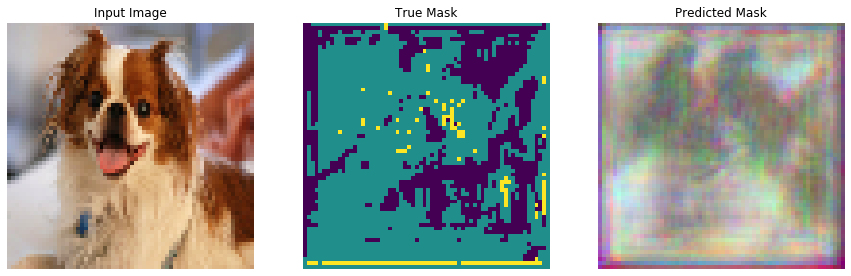

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


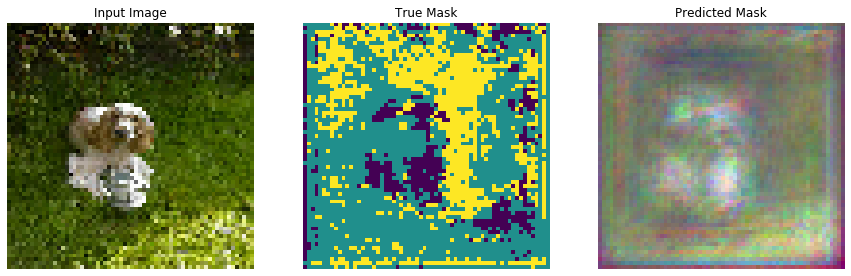

Training loss (for one batch) at step 35: loss: 0.9684216380119324 recons_loss: 0.39513733983039856
Seen so far: 432 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


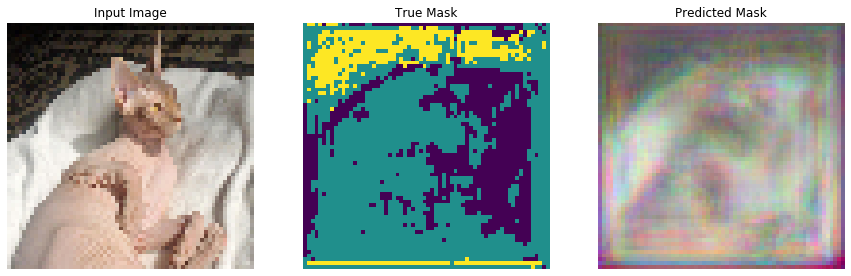

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


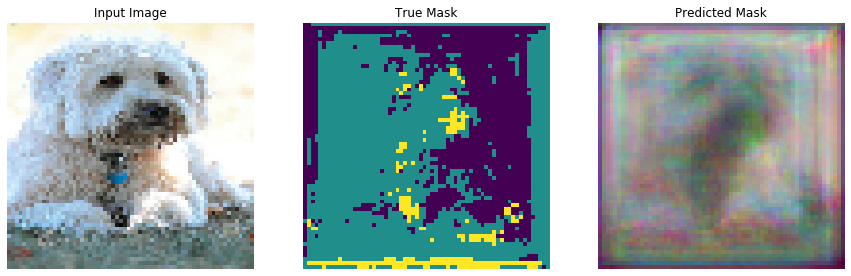

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


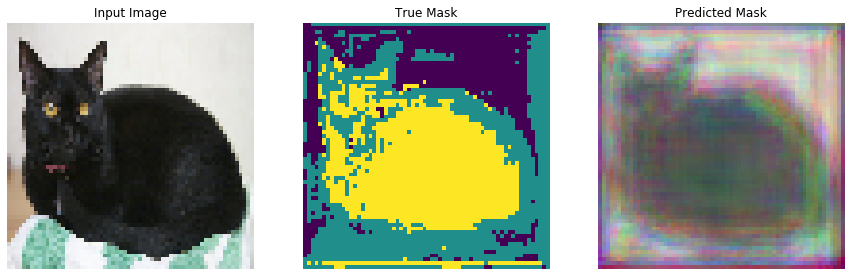

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


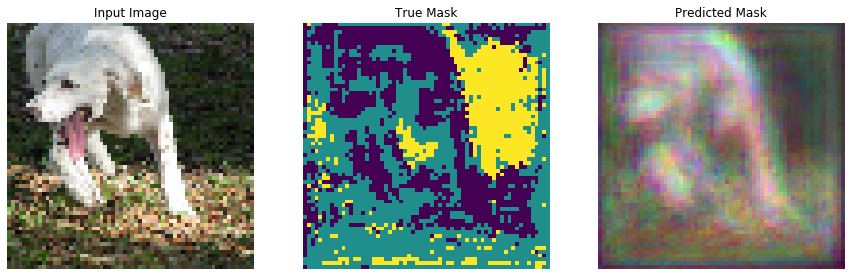

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


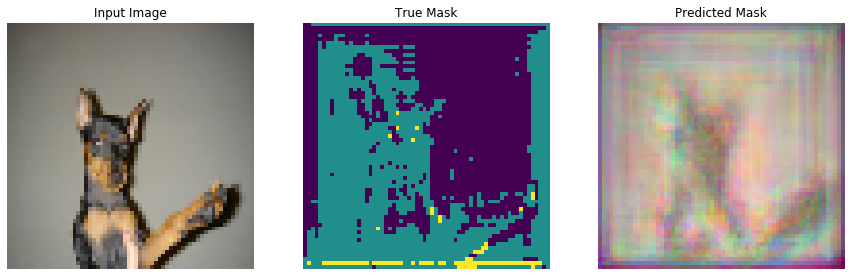

Training loss (for one batch) at step 40: loss: 0.9618861675262451 recons_loss: 0.29186755418777466
Seen so far: 492 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


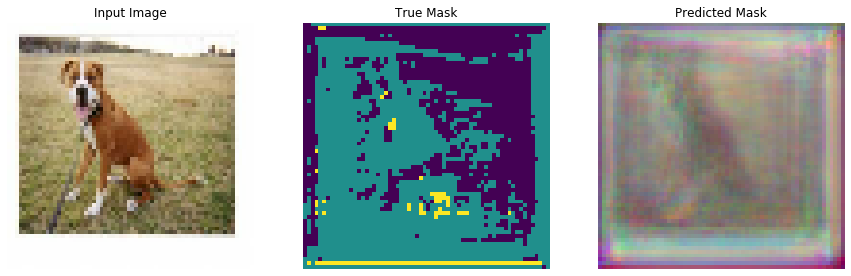

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


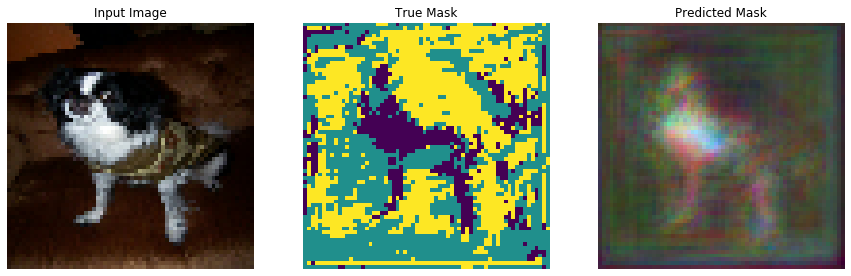

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


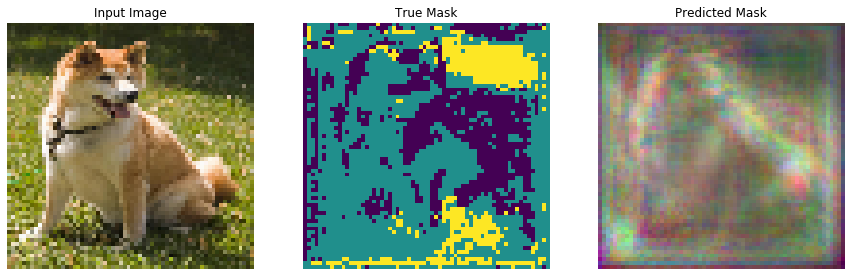

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


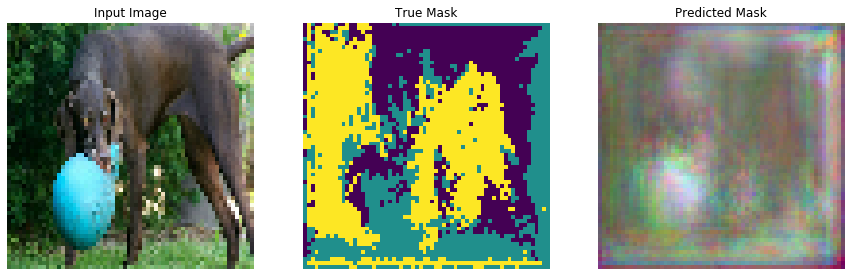

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


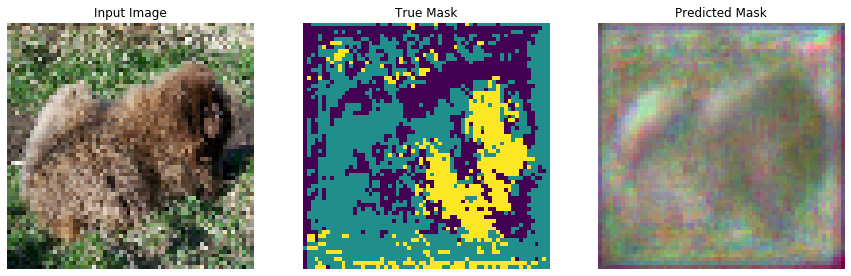

Training loss (for one batch) at step 45: loss: 0.9533340930938721 recons_loss: 0.307683527469635
Seen so far: 552 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


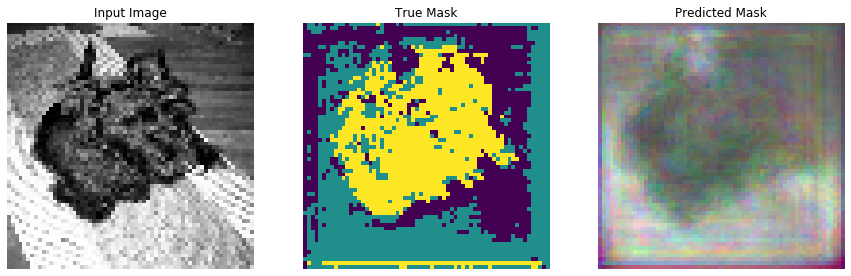

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


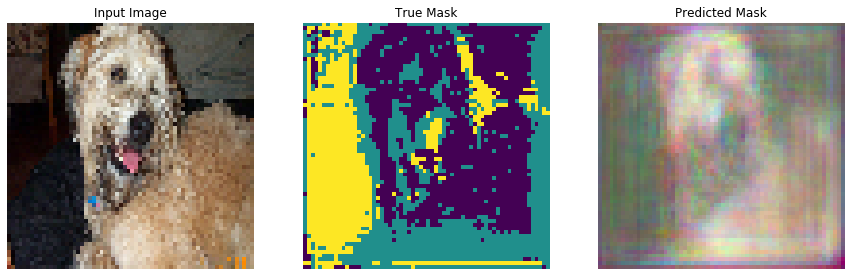

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


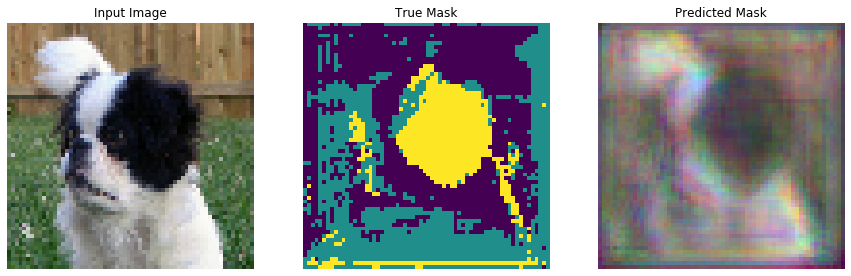

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


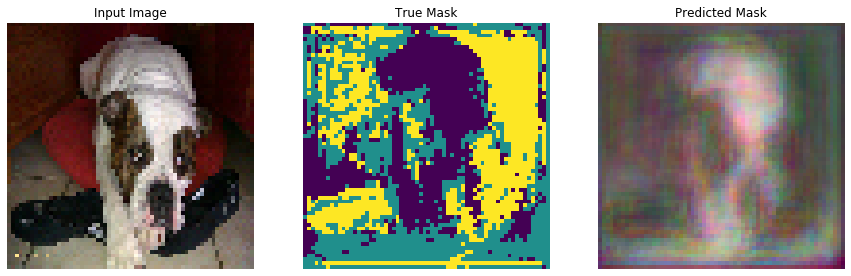

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


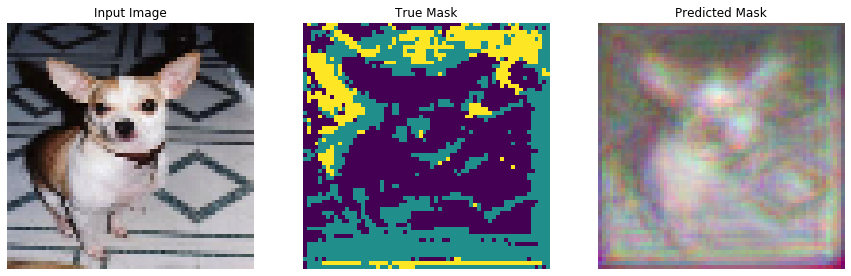

Training loss (for one batch) at step 50: loss: 0.9498357176780701 recons_loss: 0.3244955539703369
Seen so far: 612 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


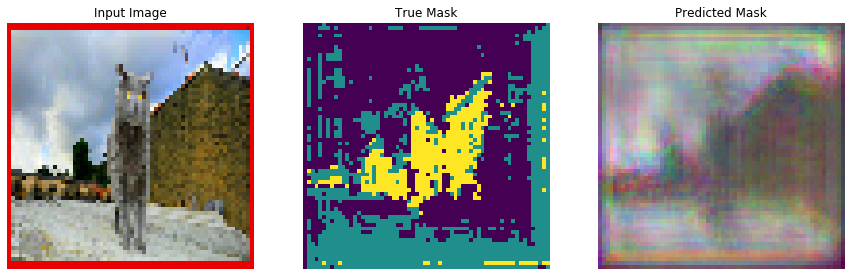

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


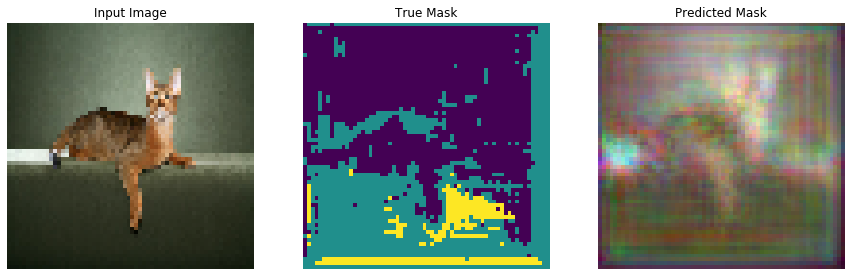

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


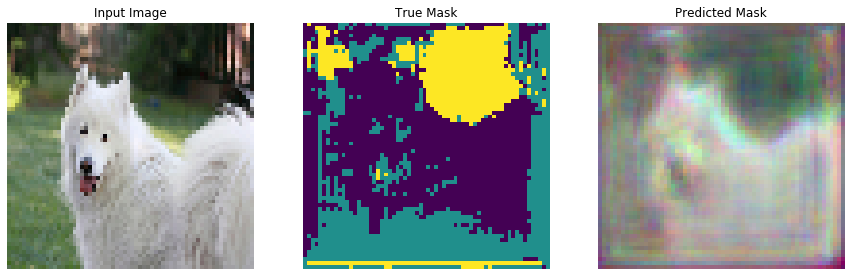

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


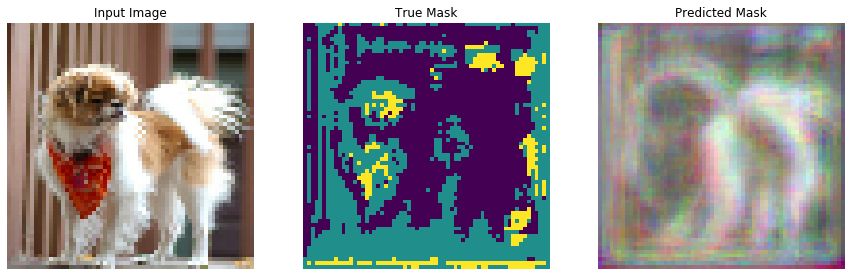

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


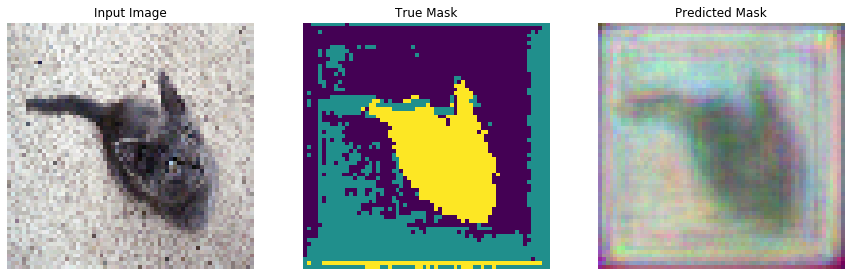

Training loss (for one batch) at step 55: loss: 0.9393434524536133 recons_loss: 0.30030444264411926
Seen so far: 672 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


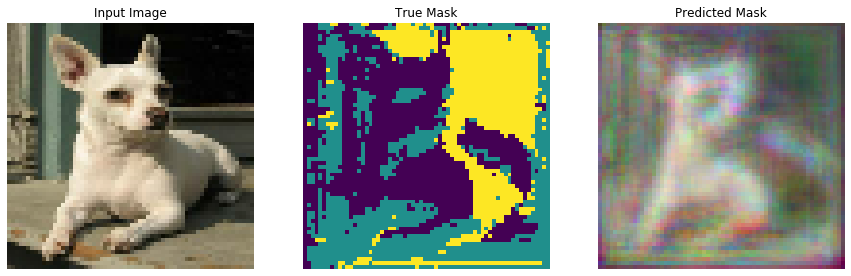

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


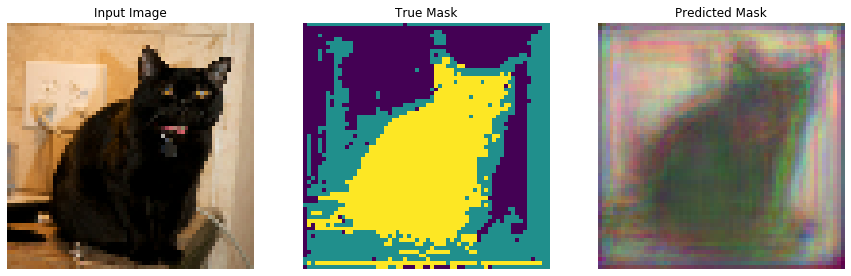

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


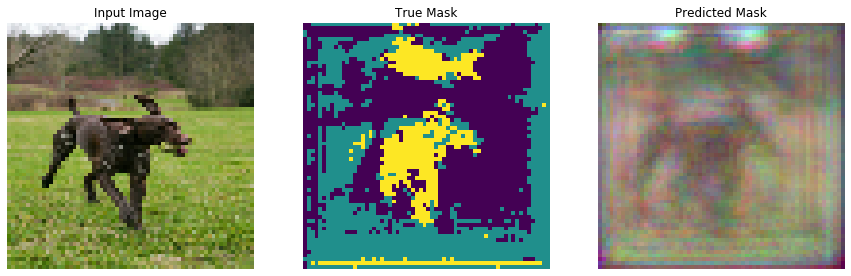

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


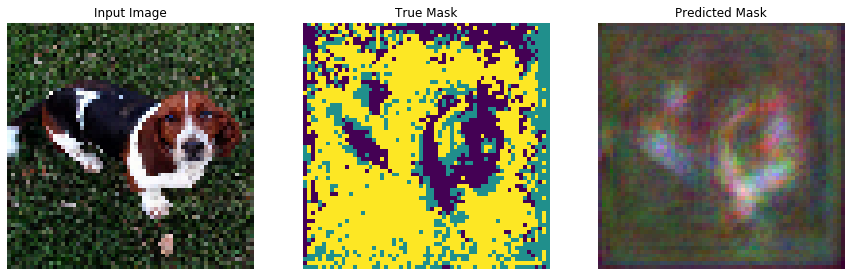

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


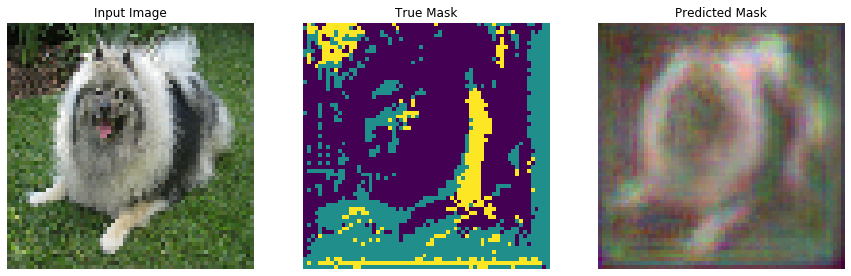

Training loss (for one batch) at step 60: loss: 0.9482573866844177 recons_loss: 0.2614809572696686
Seen so far: 732 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


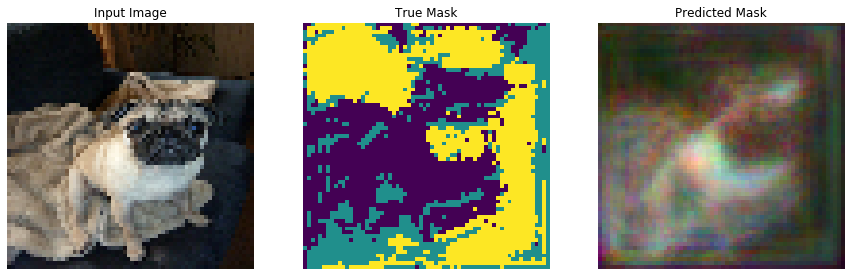

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


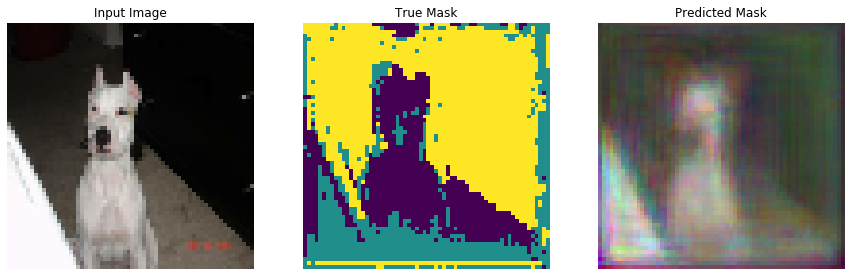

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


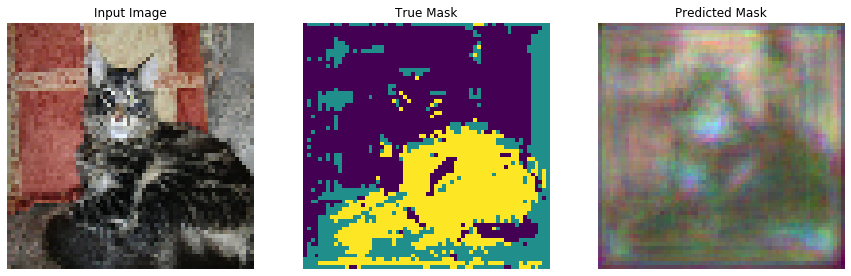

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


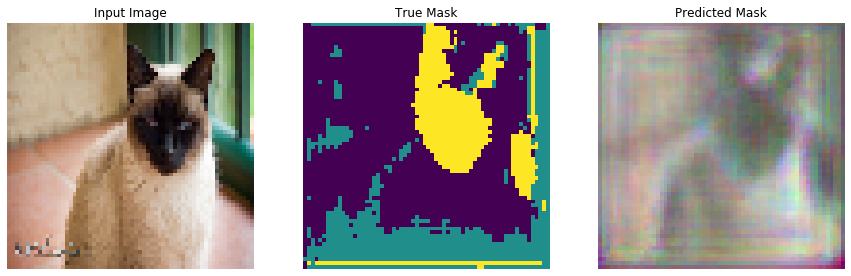

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


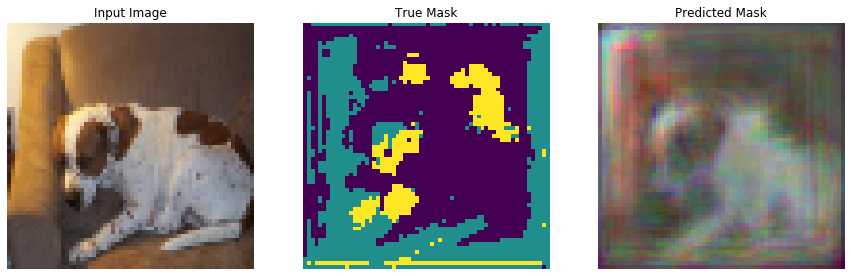

Training loss (for one batch) at step 65: loss: 0.9432768225669861 recons_loss: 0.25172531604766846
Seen so far: 792 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


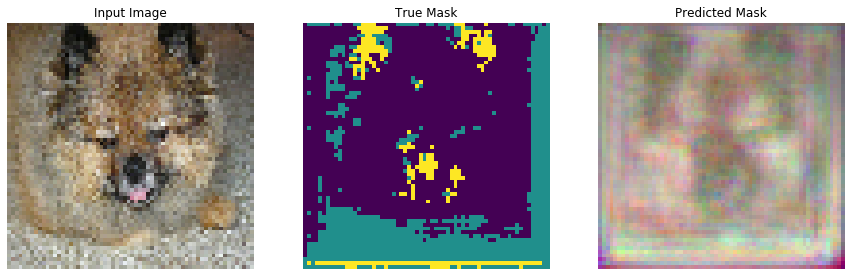

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


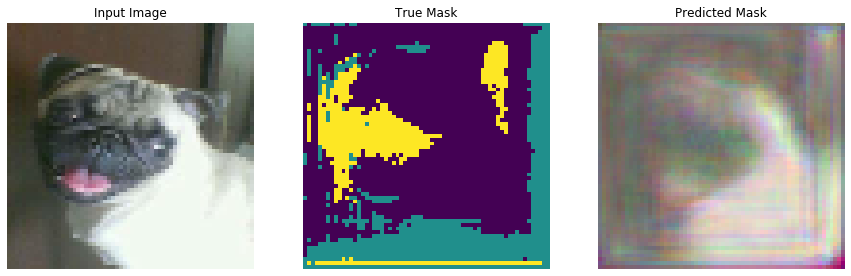

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


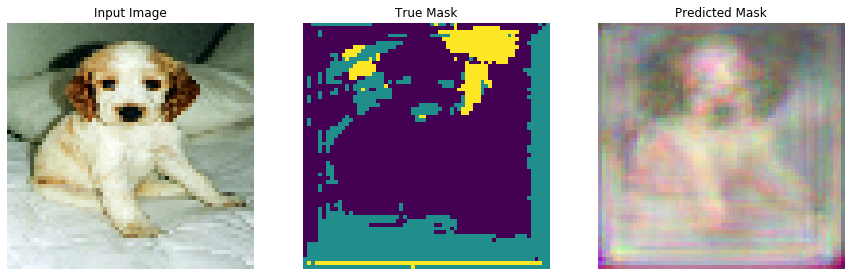

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


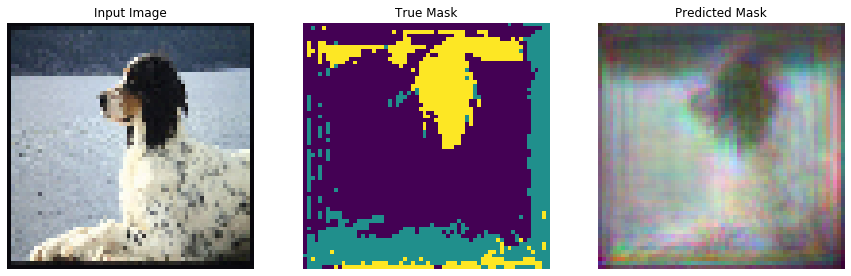

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


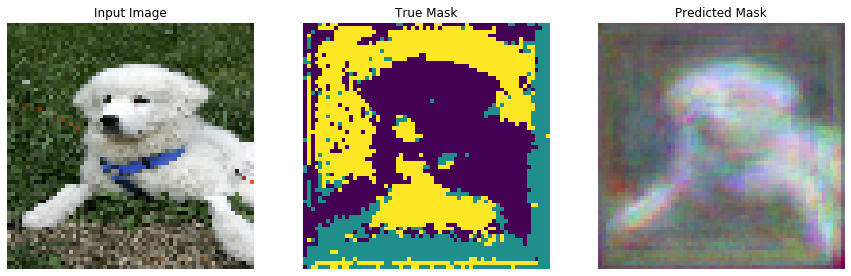

Training loss (for one batch) at step 70: loss: 0.9273496270179749 recons_loss: 0.28392404317855835
Seen so far: 852 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


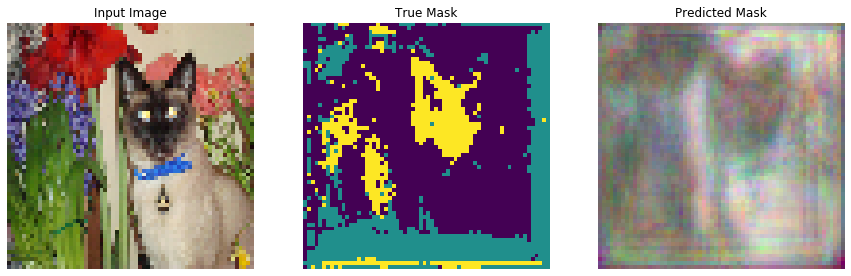

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


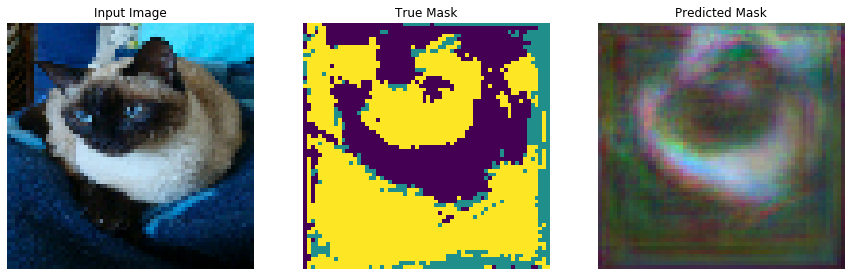

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


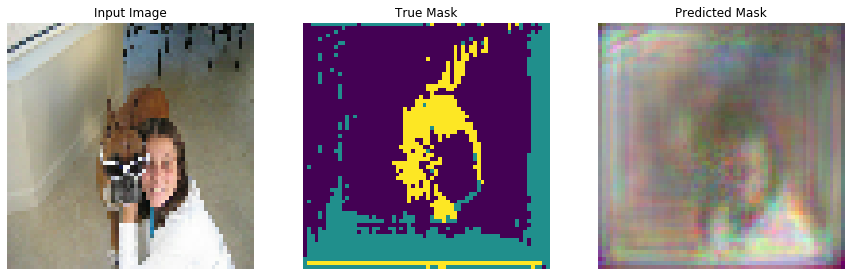

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


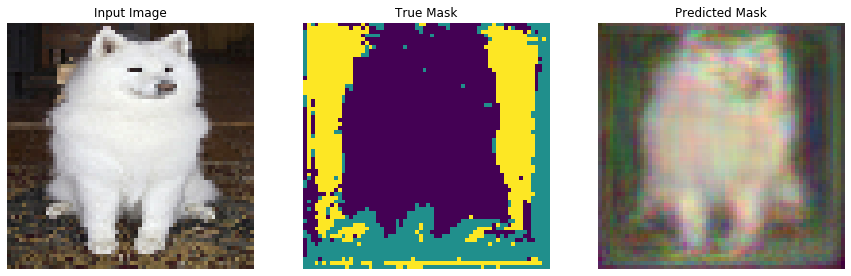

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


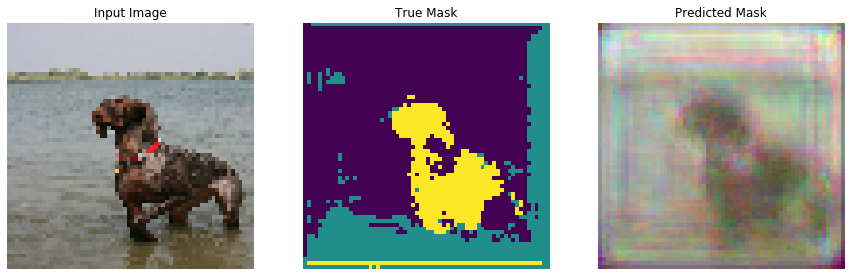

Training loss (for one batch) at step 75: loss: 0.9412444233894348 recons_loss: 0.20682929456233978
Seen so far: 912 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


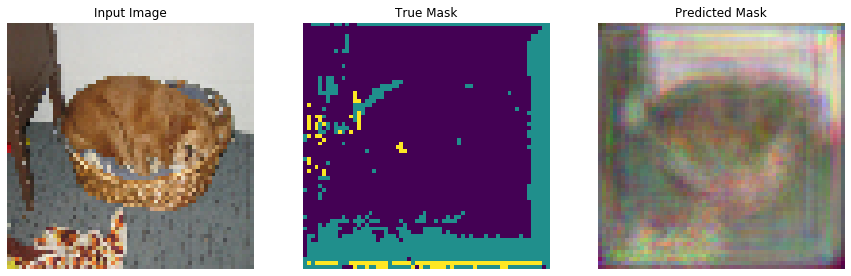

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


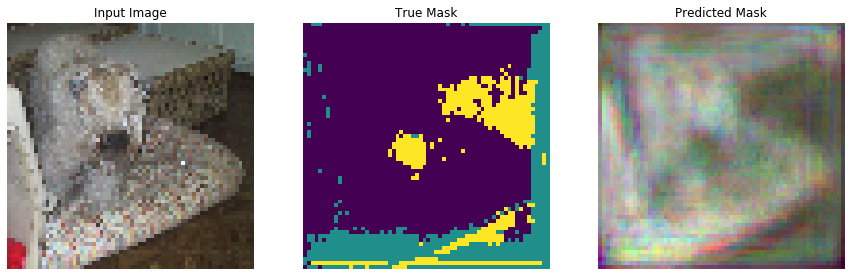

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


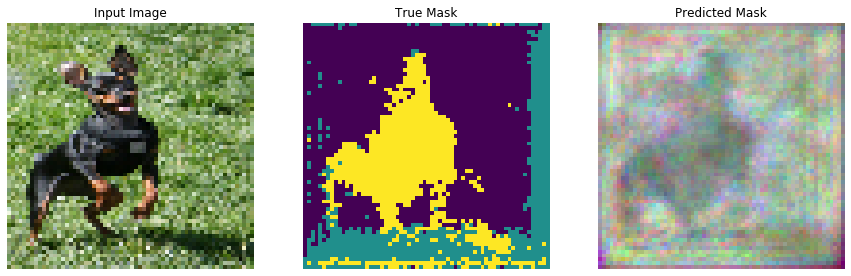

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


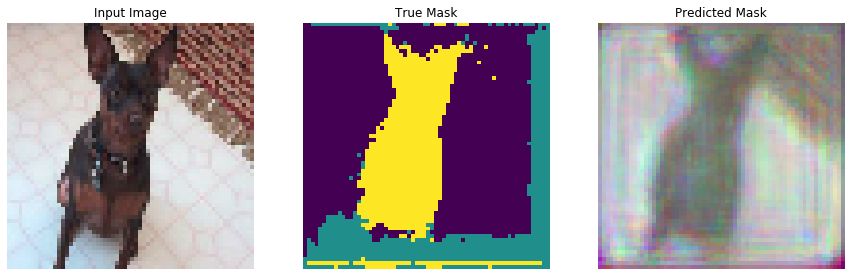

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


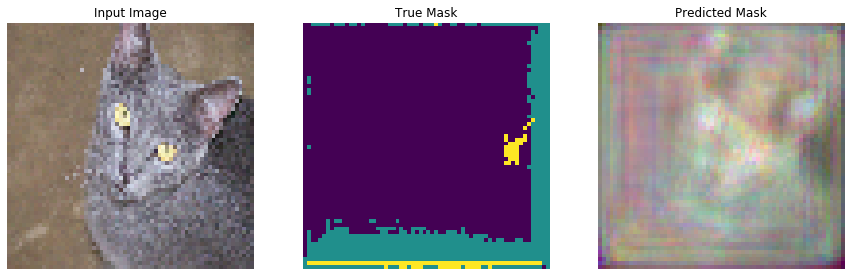

Training loss (for one batch) at step 80: loss: 0.8983452916145325 recons_loss: 0.26017189025878906
Seen so far: 972 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


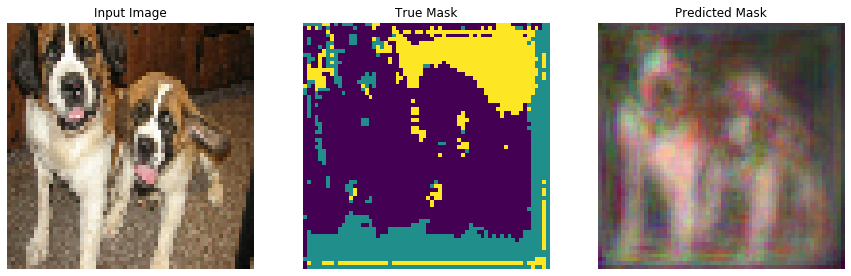

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


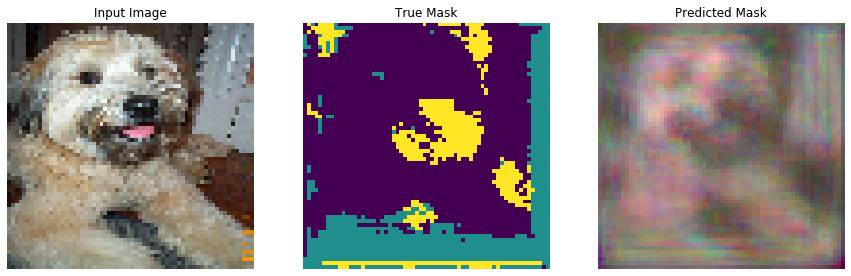

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


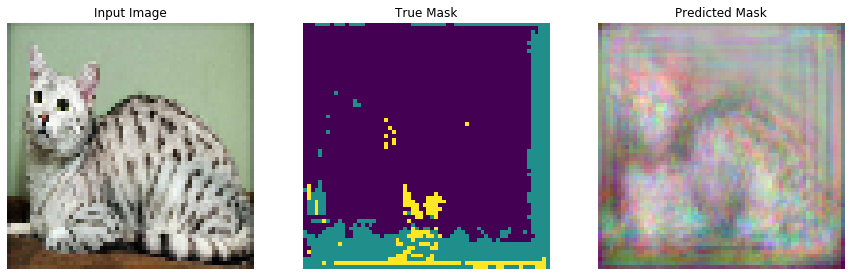

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


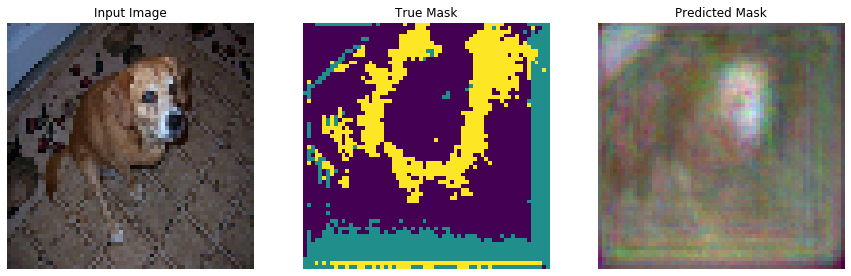

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


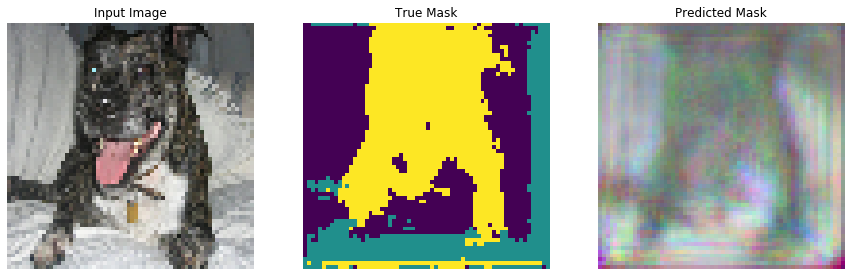

Training loss (for one batch) at step 85: loss: 0.8805829882621765 recons_loss: 0.2657391428947449
Seen so far: 1032 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


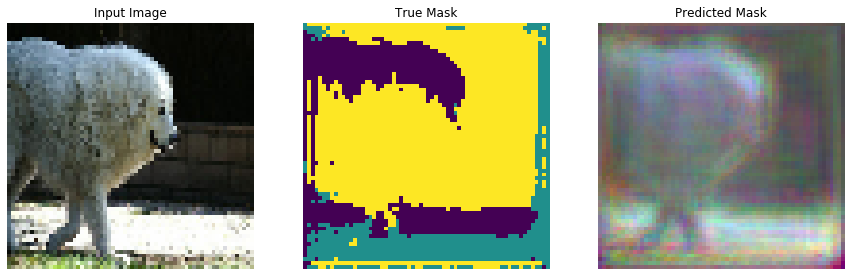

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


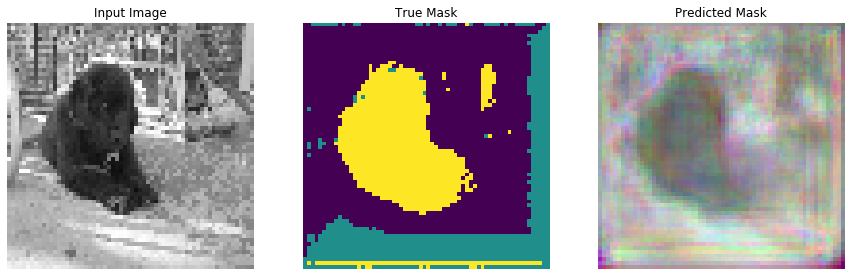

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


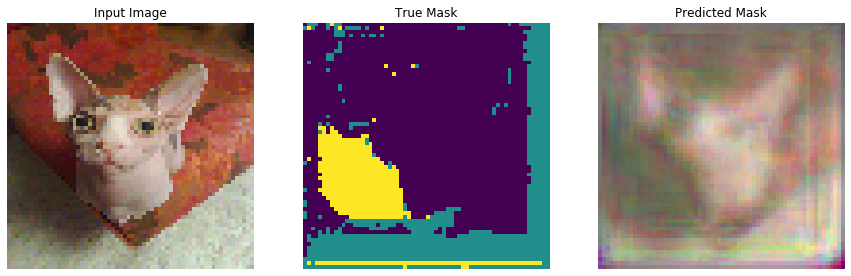

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


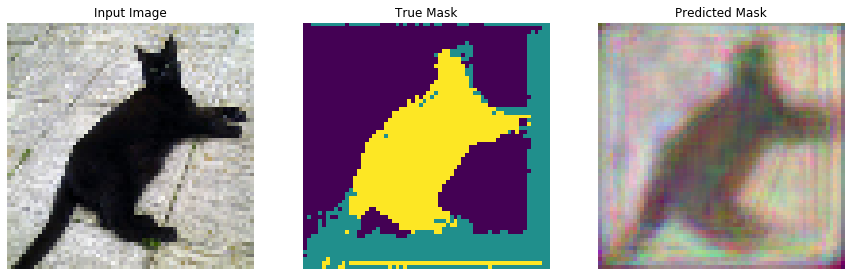

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


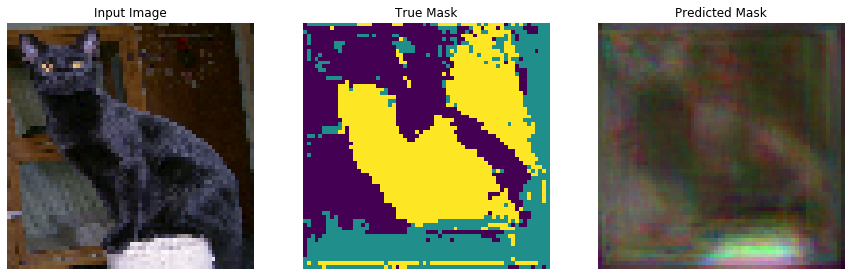

Training loss (for one batch) at step 90: loss: 0.9002458453178406 recons_loss: 0.2434542030096054
Seen so far: 1092 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


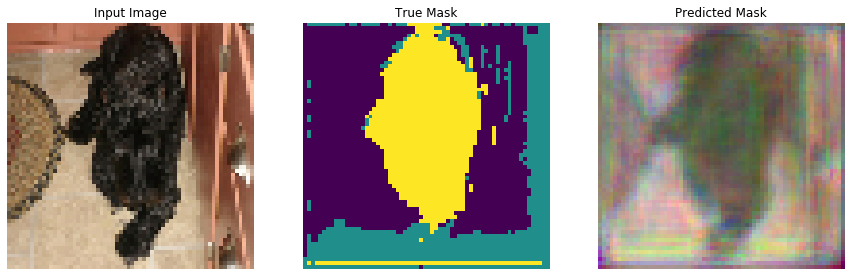

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


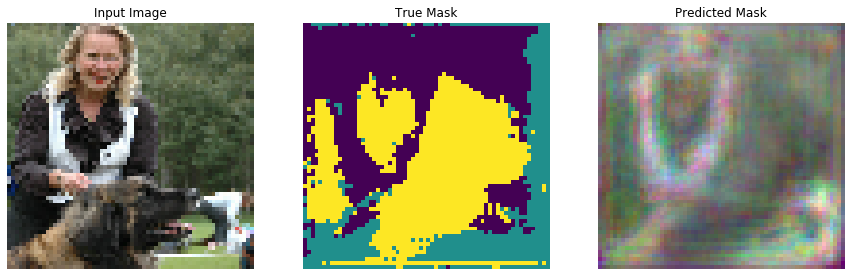

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


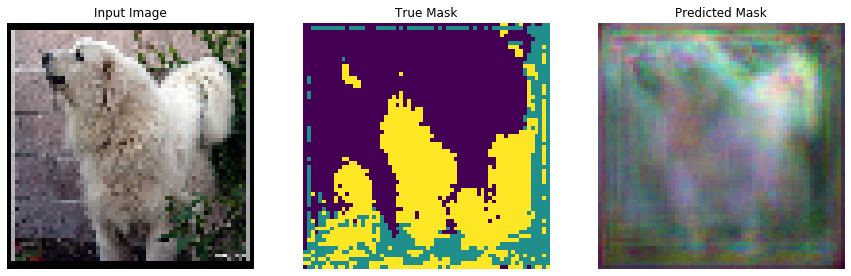

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


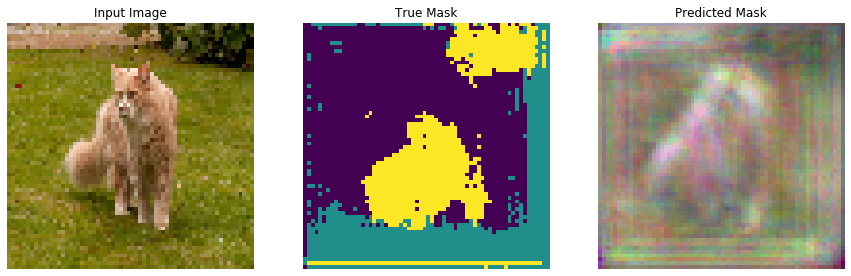

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


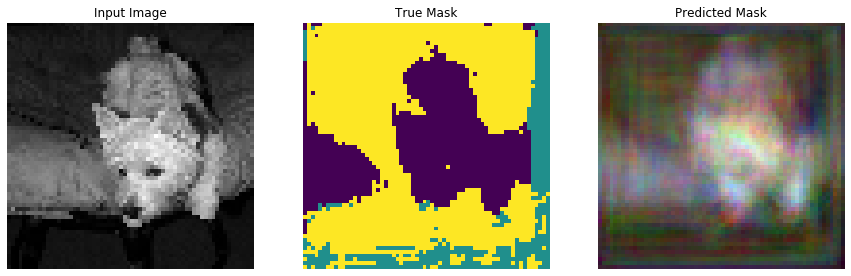

Training loss (for one batch) at step 95: loss: 0.8831585049629211 recons_loss: 0.20094706118106842
Seen so far: 1152 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


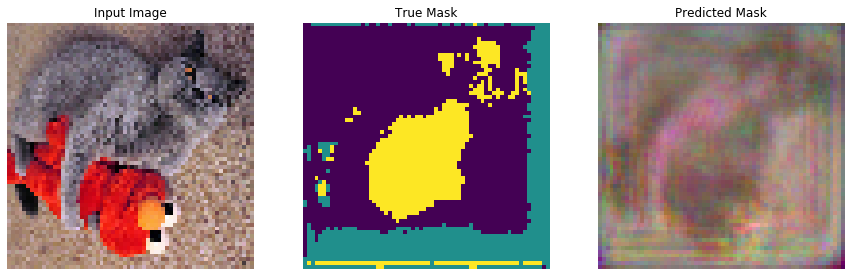

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


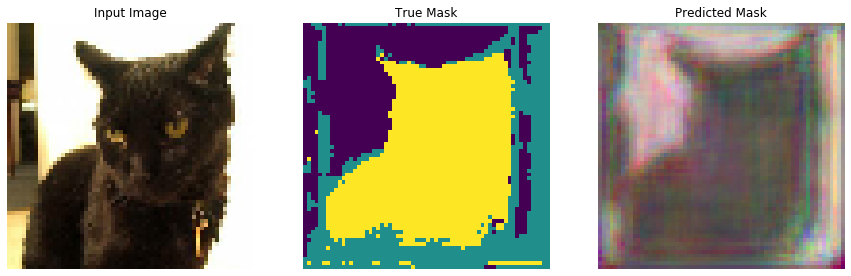

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


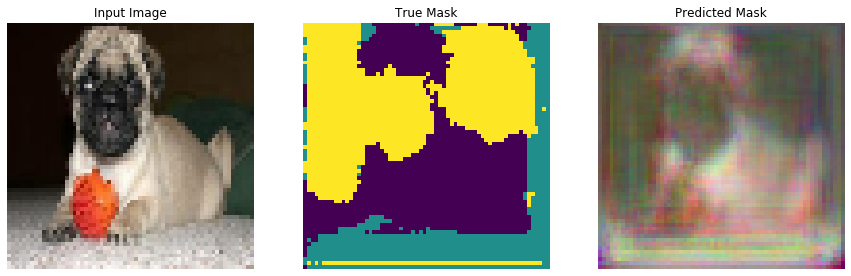

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


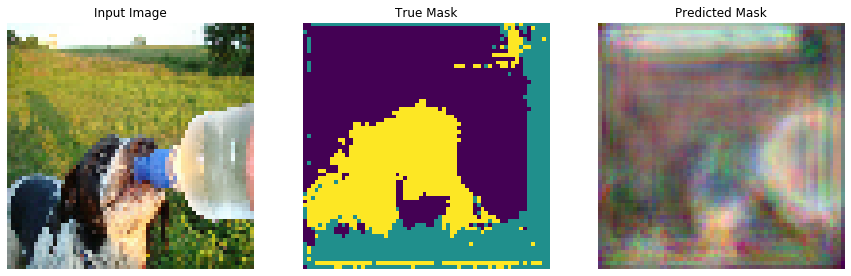

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


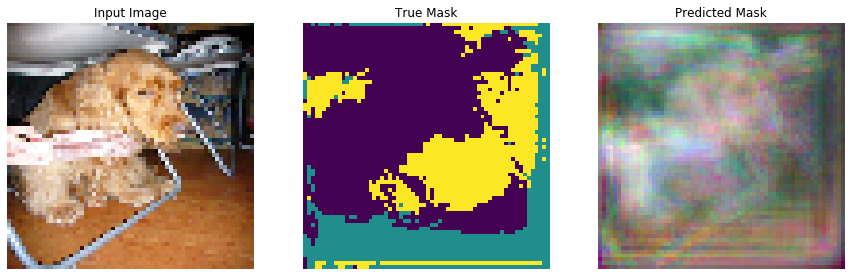

Training loss (for one batch) at step 100: loss: 0.8009123206138611 recons_loss: 0.2557213604450226
Seen so far: 1212 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


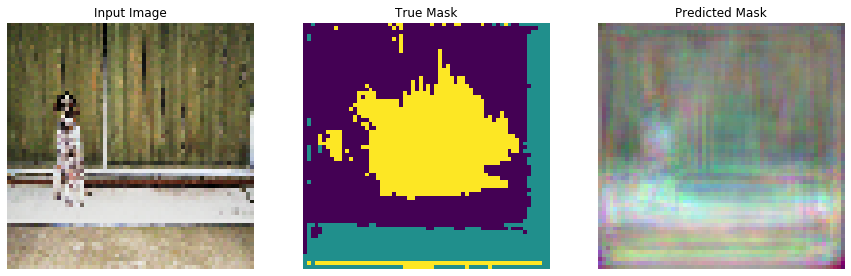

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


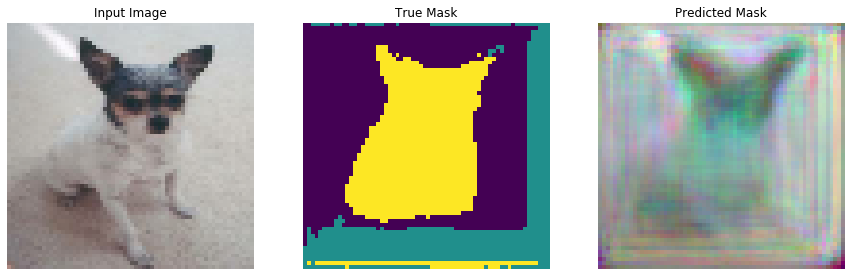

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


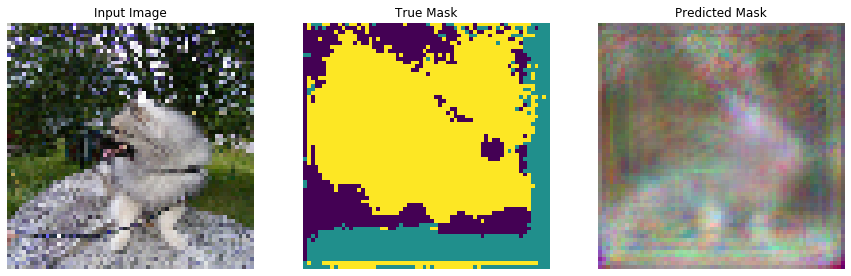

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


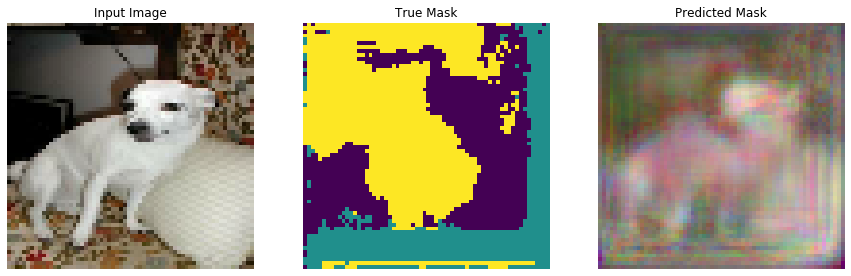

(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


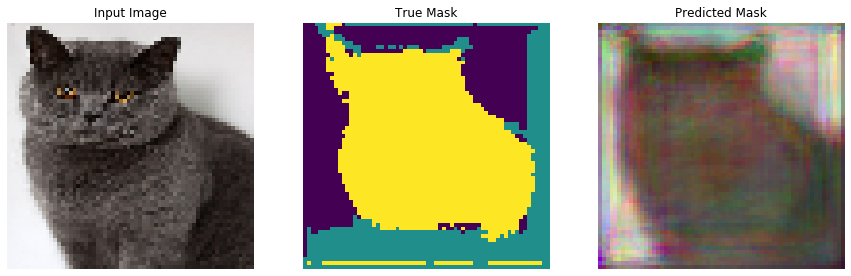

Training loss (for one batch) at step 105: loss: 0.743111789226532 recons_loss: 0.2680151164531708
Seen so far: 1272 samples
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)
(4096, 4096)


In [0]:
#Define training loop

epochs = 3
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape(persistent=True) as tape:

      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      output, decode = model(x_batch_train)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss, recons_loss = custom_loss(x_batch_train, decode, output)
      #print(loss)

    vars_encoder=[]
    # Obtain encoder variables
    for var in model.trainable_variables:
      if var.name.startswith("ENCODER"):
        vars_encoder.append(var)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    enc_grads = tape.gradient(loss, vars_encoder)
    grads = tape.gradient(recons_loss, model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(enc_grads, vars_encoder))
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    #Print result
    pred_mask = output[0]
    display([x_batch_train[0], create_mask(pred_mask), decode[0]])

    # Log every 5 batches.
    if step % 5 == 0:
        print('Training loss (for one batch) at step %s: loss: %s recons_loss: %s' % (step, float(loss), float(recons_loss)))
        print('Seen so far: %s samples' % ((step + 1) * 12))


PRUEBAS

In [0]:
recons_map = (x_batch_train, decode)
recons_loss = tf.map_fn(lambda x: tf.reduce_mean(tf.square(x[0] - x[1])), recons_map, dtype=x_batch_train.dtype)

reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(decode, x_batch_train)))
recons_loss = tf.reduce_mean(recons_loss)

mse = tf.keras.losses.MeanSquaredError()
loss = mse(x_batch_train, decode)

print(recons_loss)
print(reconstruction_error)
print(loss)